# Import packages

In [0]:
try:
  import matminer
except ModuleNotFoundError:
  !pip install matminer

In [0]:
import requests
import numpy as np 
import pandas as pd
import pickle
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [0]:
from pymatgen.io.cif import CifParser
from pymatgen.core import periodic_table
from pymatgen.core.composition import Composition
from pymatgen import Structure

from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from matminer.utils.conversions import str_to_composition
from matminer.utils.conversions import dict_to_object
from matminer.utils.conversions import composition_to_oxidcomposition

from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.structure import RadialDistributionFunction
from matminer.featurizers.composition import OxidationStates
from matminer.featurizers.composition import ValenceOrbital

# User Input

In [0]:
#@title Database

api_key = '' #@param {type:"string"}
pname = 'band_gap' #@param {type:"string"}


In [0]:
#@title Save data locally?

save_flag = False #@param {type:"boolean"}

dpath = '/gdrive/' #@param {type:"string"}
dname = 'LiFeO_bg' #@param {type:"string"}

if dname == None or dname == '':
  dname = pname

if dpath == None:
  dpath = ''
  
if save_flag:
  from google.colab import drive
  drive.mount('/gdrive')

In [55]:
#@title Filtering entries for model development

chemistry = 'Li,Fe,O' #@param {type:"string"}
stab = 1.0 #@param {type:"number"}
pmin = 0.5 #@param {type:"raw"}
pmax = None #@param {type:"raw"}
check_entries =True #@param {type:"boolean"}

elems = list(chemistry.split(","))

if check_entries:

  mpdr = MPDataRetrieval(api_key)

  # construct dict for criteria based on user inpu
  cri={pname: {"$exists": True,'$gt':0.0},
          ("{}.warnings".format(pname)): None}
  if pmin:
    cri[pname].update({'$gt':pmin})
  if pmax:
    cri[pname].update({'$lt':pmax})
  if np.sum([bool(re.search('[a-zA-Z]', item)) for item in elems]):
    cri['elements'] = {'$all':elems}
  if stab:
    cri['e_above_hull'] = {"$lt": stab}

  # load data
  props = mpdr.get_dataframe(criteria=cri,
                           properties=['pretty_formula',pname,'e_above_hull'])

  print("There are {} entries satisfying the criteria".format(props[pname].count()))


There are 1656 entries satisfying the criteria


# Functions

## Getting data

In [0]:
def query_data(pname,api_key,save=False,dname=None,path='',elems='',pmin=None,pmax=None,stab=None):

  mpdr = MPDataRetrieval(api_key)
  
  # construct dict for criteria based on user inpu
  cri={pname: {"$exists": True,'$gt':0.0},
          ("{}.warnings".format(pname)): None}
  if pmin:
    cri[pname].update({'$gt':pmin})
  if pmax:
    cri[pname].update({'$lt':pmax})
  if np.sum([bool(re.search('[a-zA-Z]', item)) for item in elems]):
    cri['elements'] = {'$all':elems}
  if stab:
    cri['e_above_hull'] = {"$lt": stab}
  
  # load data
  props = mpdr.get_dataframe(criteria=cri,
                           properties=['pretty_formula',pname,'e_above_hull'])
  
  print("There are {} entries satisfying criteria".format(props[pname].count()))

  # Load crystal structures
  # initialize dataframe
  structures = pd.DataFrame(columns=['structure'])

  # lists of mp ids to avoid server-side errors
  chunk_size = 1000
  mp_ids = props.index.tolist()
  sublists = [mp_ids[i:i+chunk_size] for i in range(0, len(mp_ids), chunk_size)]

  # query structures 
  print('Loading structures...')
  for sublist in sublists:
    structures = structures.append(mpdr.get_dataframe({"material_id":{"$in": sublist}}, ['structure']))
  
  data = pd.concat([props,structures],axis=1)
  
  # if limit:
  #  data = filter_data(data,elems,pname,pmin,pmax,stab)
  #  print('Filters applied, %d entries left' % len(data))
  
  if save:
    if not dname:
      dname = pname
    
    fname = '%s/%s.pkl' % (path,dname) 
    data.to_pickle(fname)
    print('Saved raw data to ',fname)

  return data

## Adding features

In [0]:
def add_atom_features(df):
  
  avg_row = []
  avg_col = []
  avg_num = []
  el_neg = []
  at_mass = []
  at_r = []
  io_r = []
  ox_min = []
  ox_max = []
  
  elem_list = dir(periodic_table.Element)
  a = [s for s in elem_list if "_" not in s]
  v = [0.0]*len(a)
  chem = np.zeros((len(v),len(df)))
  
  i = 0
  # loop through entries
  for index, row in df.iterrows(): 
    
    comp = Composition(row['pretty_formula'])
    elem,fracs = zip(*comp.fractional_composition.items())
    
    chem[:,i] = encode_chem(row['pretty_formula'],elem_list,v)

    # 0. average row in the periodic table
    try:
      avg_row.append(sum([el.row*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      avg_row.append(float('nan'))
    
    # 1. average column in the periodic table
    try:
      avg_col.append(sum([el.group*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      avg_col.append(float('nan'))
  
    # 2. average atomic number
    try:
      avg_num.append(sum([el.number*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      avg_num.append(float('nan'))
    
    # 3. average electronegativity
    try:
      el_neg.append(sum([el.X*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      el_neg.append(float('nan'))
    
    # 4. average atomic mass
    try:
      at_mass.append(sum([el.data['Atomic mass']*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      at_mass.append(float('nan'))
    
    # 5. average atomic radius
    try:
      at_r.append(sum([el.data['Atomic radius']*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      at_r.append(float('nan'))
    
    # 6. average ionic radius
    try:
      io_r.append(sum([el.average_ionic_radius*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      io_r.append(float('nan'))
      
    # 7. average max oxidation state
    try:
      ox_max.append(sum([el.max_oxidation_state*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      ox_max.append(float('nan'))
      
    # 8. average min oxidation state
    try:
      ox_min.append(sum([el.min_oxidation_state*fr for (el,fr) in zip(elem,fracs)]))
    except TypeError:
      ox_min.append(float('nan'))
    
    i = i + 1
      
  df['avg row'] = pd.Series(avg_row, index=df.index)
  df['avg column'] = pd.Series(avg_col, index=df.index)
  df['avg num'] = pd.Series(avg_num, index=df.index)
  df['avg el-neg'] = pd.Series(el_neg, index=df.index)
  df['avg atom mass'] = pd.Series(at_mass, index=df.index)
  df['avg atom radius'] = pd.Series(at_r, index=df.index)
  df['avg ionic radius'] = pd.Series(io_r, index=df.index)
  
  df['avg max ox state'] = pd.Series(ox_max, index=df.index)
  df['avg min ox state'] = pd.Series(ox_min, index=df.index)
  
  # for i in range(len(v)):
  #  df['el_'+str(i+1)] = pd.Series(list(chem[i,:]), index=df.index)
  
  print('Done adding atomic features')
  feat_labels = ['avg row','avg column','avg num','avg el-neg',
                 'avg atom mass','avg atom radius','avg ionic radius',
                 'avg max ox state','avg min ox state']
  
  return df

def encode_chem(pretty_formula,elem_list,v):
  '''encode chemistry'''
  
  comp = Composition(pretty_formula).fractional_composition
  elements = comp.elements
  
  for el in elements:
    v[elem_list.index(el.name)] = comp[el]

  return v

def add_cs_features(df,rdf_flag=False):

  df["composition"] = str_to_composition(df["pretty_formula"]) 
  print('Created composition column')
  # df["composition_oxid"] = composition_to_oxidcomposition(df["composition"])
  # print('Created composition_oxid column')
  df["structure"] = dict_to_object(df["structure"]) 
  print('Created structure column')

  vo = ValenceOrbital()
  df = vo.featurize_dataframe(df,"composition",ignore_errors=True)

  # ox = OxidationStates()
  # df = ox.featurize_dataframe(df, "composition_oxid",ignore_errors=True)
  
  # structure features
  den = DensityFeatures()
  df = den.featurize_dataframe(df, "structure",ignore_errors=True)
  
  if rdf_flag:
    rdf = RadialDistributionFunction(cutoff=15.0,bin_size=0.2)
    df = rdf.featurize_dataframe(df, "structure") 
  
  return df

def add_features(df,save=False,dname=None,path=''):
  '''Add features to dataframe'''
  
  df = add_atom_features(df)
  df = add_cs_features(df)
  
  
  if save:
    if not dname:
      dname = pname
      
    fname = '%s/%s_feats.pkl' % (path,dname) 
    data.to_pickle(fname)
    print('Saved data with features to ',fname)
  
  return df

## Contructing input vector

In [0]:
def get_xy(df,pname): #,elems,pname,pmin,pmax,stab):
  '''Get x and y from data'''

  # # filter NaNs and entries based on criteria
  df = df.dropna()
  # df = filter_data(df,elems,pname,pmin=pmin,pmax=pmax,stab=stab)

  # exclude non-input columns
  labels = ['pretty_formula',pname,'e_above_hull','structure','composition','composition_oxid','radial distribution function']
  exclude = []
  for item in labels:
    if item in df.columns.values:
      exclude.append(item)


  # get X and Y
  x = df.sort_index().drop(exclude, axis=1)
  y = df[pname].sort_index().values

  return x,y

In [0]:
def filter_data(df,elems,pname,pmin=None,pmax=None,stab=None):
  '''Filter data by criteria'''

  print('# entries before filters: ',len(df))

  # filter by chemistry
  inds = np.zeros((len(elems),len(df)))
  for i,item in enumerate(elems):
    inds[i,:] = (df['pretty_formula'].str.contains(item))

  idx = np.prod(inds,axis=0)
  df = df[idx==1]
  print('# entries after chemistry: ',len(df))

  # filter by property values
  if pmin:
    df = df[df[pname] >= pmin]
  if pmax:
    df = df[df[pname] <= pmax]
  print('# entries after property: ',len(df))

  # filter by stability
  if stab:
    df = df[df['e_above_hull'] <= stab]
  print('# entries after stability: ',len(df))

  return df

## Fitting random forest model 

In [0]:
def fit_forest(x,y,fast=False,lbl='Full'):

  # split data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # grid-search optimal parameters
  rf = RandomForestRegressor()
  if fast:
    param_grid = { 
        'n_estimators'      : [10,50,100,250],
        'max_features'      : ['auto','sqrt','log2'],
        'min_samples_split' : [4],
        'min_samples_leaf'  : [1]
        }    
  else:
    param_grid = { 
        'n_estimators'      : [10,25,50,100,250],
        'max_features'      : ['auto','sqrt','log2'],
        'min_samples_split' : [2,4,8],
        'min_samples_leaf'  : [1, 2, 5]
        }
  grid = GridSearchCV(rf, param_grid, n_jobs=-1, cv=5)
  grid.fit(x_train, y_train)

  print(grid.best_score_)
  print(grid.best_params_)
  print(grid.score(x_test, y_test))

  # use optimal parameters
  rf.set_params(**grid.best_params_)
  rf.fit(x_train, y_train)

  y_hat_train = rf.predict(x_train) 
  y_hat_test = rf.predict(x_test) 

  mae_train = np.mean(abs(y_hat_train-y_train))/np.mean(y_train)
  print('%s RF, train error: %.3f' % (lbl,mae_train))

  mae_test = np.mean(abs(y_hat_test-y_test))/np.mean(y_test)
  print('%s RF, test error : %.3f' % (lbl,mae_test))

  return rf

def fit_model(x,y,fast=False,show=False,save=False,dname=None,path=''):

  # fit RF using all variables
  print('Fitting full random forest...')
  rf = fit_forest(x,y,fast=fast,lbl='Full')

  # variable importances
  nvar = 10
  imp = rf.feature_importances_
  idx = np.argsort(imp)[::-1]
  print('%d most important variables:' % nvar)
  print(x.columns.values[idx][0:nvar])

  # prune variables
  thr = np.median(imp)
  idx = imp < thr
  exclude = list(x.columns.values[idx])
  x_sel = x.drop(exclude, axis=1)
  x_sel_cols = x_sel.columns.values
  
  # fit RF using important variables
  print('\nFitting pruned random forest...')
  rf = fit_forest(x_sel,y,fast=fast,lbl='Pruned')
  
  print('%d pruned variables:' % len(x_sel.columns))
  print(x_sel_cols)
  
  if save:
    if not dname:
      dname = pname
      
    fname = '%s/%s_model.pkl' % (path,dname) 
    f = open(fname, "wb")
    pickle.dump(rf, f)
    pickle.dump(list(x_sel_cols), f)
    f.close()
  
  if show:
    # plt.figure(figsize=(7, 4))

    # importance chart
    plt.subplot(121)
    
    ind = np.argsort(imp)[::-1]
    plt.bar(x=x.columns.values[ind][0:nvar], height=imp[ind][0:nvar],color=(0.3,0.3,0.9))
    plt.xticks(x.columns.values[ind][0:nvar], x.columns.values[ind][0:nvar], rotation='vertical')
    plt.xlabel('Variables')
    plt.ylabel('Importance')

    # parity plot
    ax = plt.subplot(122)
    ax.set_aspect(1)
    
    plt.scatter(y, rf.predict(x_sel),marker='s',alpha=.25,c=(0.9,0.3,0.3))
    plt.plot(np.arange(np.max(y)),c='gray')
    plt.xlabel('Ground truth')
    plt.ylabel('RF prediction')
    
    plt.subplots_adjust(bottom=0.25,top=0.75)
    plt.draw()
    plt.show()
  

  return rf,x_sel_cols


In [0]:
def digest(url):
	'''Get structure for given url of CIF file'''

	response = requests.get(url)
	data = response.text

	parser = CifParser.from_string(data)
	structure = parser.get_structures()[0]
	print('Successfuly read structure for',structure.composition)

	return structure

def get_xnew(df,x_cols):
	'''Get feature vector for new material'''

	# exclude columns non-present in x_train
	exclude = []
	for item in df.columns.values:
		if item not in x_cols:
			exclude.append(item)

	# get X 
	x = df.drop(exclude, axis=1)

	return x

def use_model(formula,CIF_path,mdl,x_cols):

	# get structure for given CIF
	structure = digest(CIF_path)

	# initialize df
	df = pd.DataFrame(columns=['pretty_formula','structure'])

	# fill df
	df["pretty_formula"] = pd.Series([formula])
	df["structure"] = pd.Series([structure])

	# add features
	df = add_atom_features(df)
	df = add_cs_features(df)

	# get x vector for new material
	xnew = get_xnew(df,x_cols)

	ynew = mdl.predict(xnew)
	print('Predicted property: %.3f' % ynew)

	return xnew,ynew

# Run the workflow

### Get data from mp database

In [62]:
%%time 

data = query_data(pname,api_key,save_flag,dname,dpath,
                  elems=elems,pmin=pmin,pmax=pmax,stab=stab)

There are 1656 entries satisfying criteria
Loading structures...
CPU times: user 987 ms, sys: 94.3 ms, total: 1.08 s
Wall time: 10.2 s


In [63]:
data.describe()

,band_gap,e_above_hull
count,1656.000000,1656.000000
mean,2.273763,0.049502
std,0.929248,0.046415
min,0.501800,0.000000
25%,1.515300,0.016632
50%,2.296750,0.047097
75%,2.982400,0.069555
max,4.602300,0.935848


### Add features to data

In [64]:
%%time 

df = add_features(data,save_flag,dname,dpath)

Done adding atomic features
Created composition column


ValenceOrbital:   0%|          | 0/1656 [00:00<?, ?it/s]

Created structure column


DensityFeatures: 100%|██████████| 1656/1656 [00:06<00:00, 244.54it/s]


CPU times: user 5.57 s, sys: 215 ms, total: 5.78 s
Wall time: 13.4 s


### Construct input vector

In [65]:
%%time
x,y = get_xy(df,pname)

CPU times: user 9.49 ms, sys: 2.05 ms, total: 11.5 ms
Wall time: 12.7 ms


### Fit RF model

Fitting full random forest...
0.7728376353117904
{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 250}
0.7914955661574609
Full RF, train error: 0.060
Full RF, test error : 0.126
10 most important variables:
['frac d valence electrons' 'avg d valence electrons' 'density'
 'frac p valence electrons' 'avg ionic radius' 'avg num' 'avg atom mass'
 'frac s valence electrons' 'avg row' 'avg atom radius']

Fitting pruned random forest...
0.7570520718743421
{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 250}
0.7917375271956291
Pruned RF, train error: 0.062
Pruned RF, test error : 0.128
10 pruned variables:
['avg row' 'avg num' 'avg atom mass' 'avg atom radius' 'avg ionic radius'
 'avg d valence electrons' 'frac s valence electrons'
 'frac p valence electrons' 'frac d valence electrons' 'density']


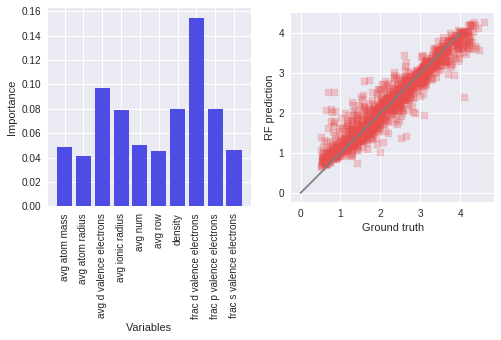

CPU times: user 4.19 s, sys: 448 ms, total: 4.64 s
Wall time: 40.6 s


In [66]:
%%time 

mdl,x_cols = fit_model(x,y,fast=True,show=True,save=save_flag,dname=dname,path=dpath)

### Use RF model for new material

In [0]:
#@title New material

formula = 'Li5FeO4' #@param {type:"string"}
CIF_url = '' #@param {type:"string"}

In [68]:
if CIF_url =='' or 'http' not in CIF_url:
  print('Correct CIF url is required')
else:
  xnew,ynew = use_model(formula,CIF_url,mdl,x_cols)

ValenceOrbital:   0%|          | 0/1 [00:00<?, ?it/s]

Successfuly read structure for Li40 Fe8 O32
Done adding atomic features
Created composition column
Created structure column


DensityFeatures: 100%|██████████| 1/1 [00:00<00:00, 37.08it/s]


Predicted property: 2.834
